## Import Packages

In [1]:
# imports
import matplotlib
import mplcursors
import numpy as np
import matplotlib.pyplot as plt
import json
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import os

from worldllm_envs.playground.playground_text_wrapper import PlayGroundText

/home/guillaumelevy/Documents/WorldLLM/.venv/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Load the data

In [2]:
# Get test trajectories from the env, verify that these are the same as the ones used in the training of the data


test_trajectories = PlayGroundText.get_test_dataset()
# Keep only the scorable observations
test_observations = []
for trajectory in test_trajectories:
    for incr, observation in enumerate(trajectory.text):
        if incr % 2 ==0 and incr != 0:
            test_observations.append(observation)
nb_transitions = len(test_observations)

In [3]:
# Load the data


shared_extension = "_trajP_wt5"
baselines_to_load = [
    "playground_metropolis_pb",
    "playground_metropolis_rb",
    "playground_metropolis_cp",
]
baselines_names = ["M2 PB",  "M2 RB", "M2 CP"]
assert len(baselines_to_load) == len(baselines_names)
all_data = {k: [] for k in baselines_names}
all_rules = {}
all_likelihoods = {}
all_transition_likelihoods = {}
all_weights = {}
all_additional_data = {}
for baseline, b_name in zip(baselines_to_load, baselines_names):
    print(
        "-------------------------------- Load "
        + baseline
        + " --------------------------------"
    )
    path_start = "./outputs/" + baseline + shared_extension + "/"
    lst_data = []
    for f_day in os.listdir(path_start):
        if os.path.isdir(path_start + f_day):
            for f_hour in os.listdir(path_start + f_day):
                if os.path.isdir(path_start + f_day + "/" + f_hour):
                    path = path_start + f_day + "/" + f_hour + "/all.json"
                    with open(path, "r") as file:
                        lst_data.append(json.load(file))
                        print("Loaded: " + path)
    # Reconstruct all rules and parse by seeds
    if "counts" in lst_data[0]["metrics"]:
        # Parse IS
        rules = []
        likelihoods = []
        transition_likelihoods = []
        weights = []
        for data in lst_data:
            rules.append(np.repeat(data["rules"], data["metrics"]["counts"]))
            likelihoods.append(
                np.repeat(
                    data["metrics"]["test_likelihoods"], data["metrics"]["counts"]
                )
            )
            weights.append(
                np.repeat(data["metrics"]["weights"], data["metrics"]["counts"])
            )
            transitions = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transitions.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            transition_likelihoods.append(np.repeat(transitions, data["metrics"]["counts"]))
                
        all_rules[b_name] = np.stack(rules)
        all_likelihoods[b_name] = np.stack(likelihoods)
        all_transition_likelihoods[b_name] = np.stack(transition_likelihoods)
        all_weights[b_name] = np.stack(weights)
    elif "prev_rules_ind" in lst_data[0]["metrics"]:
        # Parse Metropolis
        # Reconstruct all rules M
        reshaped_rules = []
        reshaped_likelihoods = []
        reshaped_transition_likelihoods = []
        reshaped_weights = []
        reshaped_prev_rules_ind = []
        for data in lst_data:
            # TODO: remove hardcoded default rule to 3
            nb_particles = (
                data["metrics"]["nb_rules"] if "nb_rules" in data["metrics"] else 3
            )
            rules = np.array(data["rules"])
            likelihoods = np.array(data["metrics"]["test_likelihoods"])
            weights = np.array(data["metrics"]["weights"])
            prev_rules_ind = np.array(data["metrics"]["prev_rules_ind"])
            transition_likelihoods = []
            for lst_trajectory_likelihood in data["metrics"]["test_transition_scores"]:
                transition_likelihoods.append([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood])
            assert len([transition for trajectory_likelihood in lst_trajectory_likelihood for transition in trajectory_likelihood]) == nb_transitions
            #Reshape to consider particle as different seeds
            reshaped_rules.append(rules.reshape((-1, nb_particles)).transpose())
            reshaped_likelihoods.append(
                likelihoods.reshape((-1, nb_particles)).transpose()
            )
            reshaped_weights.append(weights.reshape((-1, nb_particles)).transpose())
            reshaped_prev_rules_ind.append(
                prev_rules_ind.reshape((-1, nb_particles)).transpose()
            )
            reshaped_transition_likelihoods.append(
                np.array(transition_likelihoods).reshape((-1,nb_particles,nb_transitions)).transpose((1,0,2))
            )
        # Concatenate all seeds
        all_rules[b_name] = np.concatenate(reshaped_rules, axis=0)
        all_likelihoods[b_name] = np.concatenate(reshaped_likelihoods, axis=0)
        all_weights[b_name] = np.concatenate(reshaped_weights, axis=0)
        all_additional_data[b_name] = {
            "prev_rules_ind": np.concatenate(reshaped_prev_rules_ind, axis=0)
        }
        all_transition_likelihoods[b_name] = np.concatenate(reshaped_transition_likelihoods, axis=0)
    else:
        raise ValueError("Unknown format")
    all_data[b_name] = lst_data

-------------------------------- Load playground_metropolis_pb --------------------------------
Loaded: ./outputs/playground_metropolis_pb_trajP_wt5/2024-09-18/05-44-50_439/all.json
Loaded: ./outputs/playground_metropolis_pb_trajP_wt5/2024-09-18/05-44-17_438/all.json
-------------------------------- Load playground_metropolis_rb --------------------------------
Loaded: ./outputs/playground_metropolis_rb_trajP_wt5/2024-09-18/05-44-52_440/all.json
Loaded: ./outputs/playground_metropolis_rb_trajP_wt5/2024-09-18/05-44-51_441/all.json
-------------------------------- Load playground_metropolis_cp --------------------------------
Loaded: ./outputs/playground_metropolis_cp_trajP_wt5/2024-09-18/05-44-51_442/all.json
Loaded: ./outputs/playground_metropolis_cp_trajP_wt5/2024-09-18/05-45-08_443/all.json


In [4]:
dict_index_transition = {"standing": [], "holding": [], "holding1": [], "holding2": [], "transform":[], "transformP": [], "transformSH": [], "transformBH": [], "nothing": []}
for incr,transition in enumerate(test_observations):
    if "standing" in transition:
        dict_index_transition["standing"].append(incr)
    elif "holding" in transition:
        if " and " in transition:
            dict_index_transition["holding2"].append(incr)
        else:
            dict_index_transition["holding1"].append(incr)
        dict_index_transition["holding"].append(incr)
    elif "transform" in transition:
        if "into the carrot" in transition or "into the potato." in transition or "into the beet." in transition or "into the berry." in transition or "into the pea." in transition:
            dict_index_transition["transformP"].append(incr)
        elif "into the pig." in transition or "into the cow." in transition or "into the sheep." in transition:
            dict_index_transition["transformSH"].append(incr)
        elif "into the elephant." in transition or "into the giraffe." in transition or "into the rhinoceros." in transition:
            dict_index_transition["transformBH"].append(incr)
        else:
            raise ValueError("Unknown transform")
        dict_index_transition["transform"].append(incr)
    elif "Nothing" in transition:
        dict_index_transition["nothing"].append(incr)
    else:
        raise ValueError("Unknown transition")

In [5]:
# Get repartition of the actions:
for action in dict_index_transition:
    print(action, len(dict_index_transition[action]))

standing 51
holding 26
holding1 15
holding2 11
transform 19
transformP 13
transformSH 3
transformBH 3
nothing 21


## Rules generated

In [6]:
# Compare best rule for IS and M
# Best rules of each method
best_taken = 50
all_baselines_name = list(all_likelihoods.keys())
all_best_rules_ind = []
for b_name in all_baselines_name:
    best_rules_ind = np.argsort(-all_likelihoods[b_name].flatten())[:best_taken]
    all_best_rules_ind.append(best_rules_ind)
likelihoods = np.concatenate([all_likelihoods[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
rules = np.concatenate([all_rules[b_name].flatten()[all_best_rules_ind[incr]] for incr, b_name in enumerate(all_baselines_name)])
indices = np.argsort(-likelihoods)
all_colors_start = ["\033[31m", "\033[32m", "\033[34m", "\033[35m", "\033[36m", "\033[37m", "\033[33m", "\033[90m"]
all_colors_end = ["\033[0m"] * len(all_colors_start)
all_colors_names = ["Red", "Green", "Blue", "Magenta", "Cyan", "White", "Yellow", "Bright Black"]
# Print colors for every baselines:
print("Colors for each baselines:")
for incr, b_name in enumerate(all_baselines_name):
    print(f"Baseline: '{b_name}' Color: {all_colors_start[incr]}{all_colors_names[incr]}{all_colors_end[incr]}")
for incr, ind in enumerate(indices):
    color_start = all_colors_start[ind//best_taken]
    color_end = all_colors_end[ind//best_taken]
    print(
        f"{color_start}-----rule-----:{incr}: {repr(rules[ind])}, likelihood: {likelihoods[ind]:2f}{color_end}"
    )

Colors for each baselines:
Baseline: 'M2 PB' Color: Red
Baseline: 'M2 RB' Color: Green
Baseline: 'M2 CP' Color: Blue
-----rule-----:0: "Based on the observed object movement in the given sequences, we can create the following rules:\n\n1. If an object's location doesn't change from one observation to the next, it remains in the same location unless an action to move or collect the object occurs.\n2. An explicit action (e.g., 'You go to the...') is required to move an object to a different location or to introduce a new object into the current location.\n3. When an object is introduced and then later has its location unchanged ('Nothing has changed'), this indicates no movement occurred after its introduction.\n4. Collecting all objects at once alters their collective state but does not change their individual locations.\n5. The unchanged state after giving an object spreads throughout all objects you hold, should you collect all of them.\n6. The 'water' object can be picked up and carr

In [7]:
# Number of sames rules per particle
for b_name in all_baselines_name:
    redudant_rules = [len(all_rules[b_name][particle])- len(set(all_rules[b_name][particle])) for particle in range(all_rules[b_name].shape[0])]
    print(f"Number of same rules per particle for {b_name}: {redudant_rules}")

Number of same rules per particle for M2 PB: [7, 9, 10, 17, 19, 1]
Number of same rules per particle for M2 RB: [0, 1, 0, 0, 0, 14]
Number of same rules per particle for M2 CP: [0, 4, 6, 6, 2, 9]


## Comparison across seeds

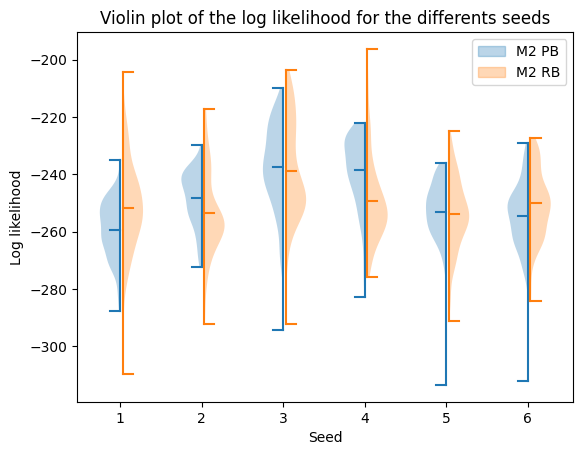

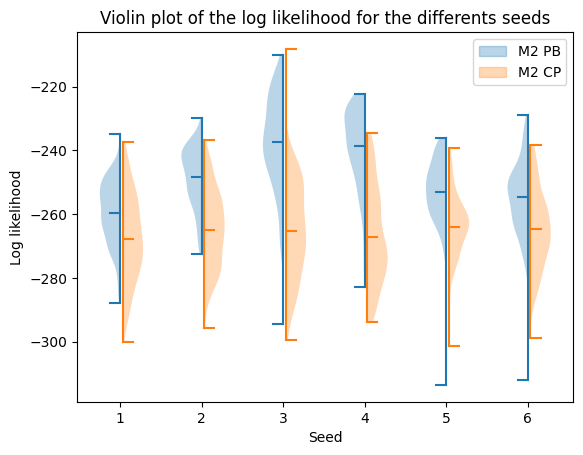

In [8]:
# Plot violin plot of the log likelihood as a function of the seeds for both algorithms
for b_name in all_baselines_name[1:]:
    plt.figure()
    color1 = plt.violinplot(all_likelihoods[all_baselines_name[0]].transpose(), showmeans=True, side = "low")["bodies"][0].get_facecolor().flatten()
    color1 = matplotlib.patches.Patch(color=color1)
    color2 = plt.violinplot(all_likelihoods[b_name].transpose(), showmeans=True, side="high", positions=[i+1.03 for i in range(len(all_likelihoods[b_name]))])["bodies"][0].get_facecolor().flatten()
    color2 = matplotlib.patches.Patch(color=color2)
    plt.legend([color1, color2], [all_baselines_name[0], b_name])
    plt.title("Violin plot of the log likelihood for the differents seeds")
    plt.xlabel("Seed")
    plt.ylabel("Log likelihood")
    plt.show()

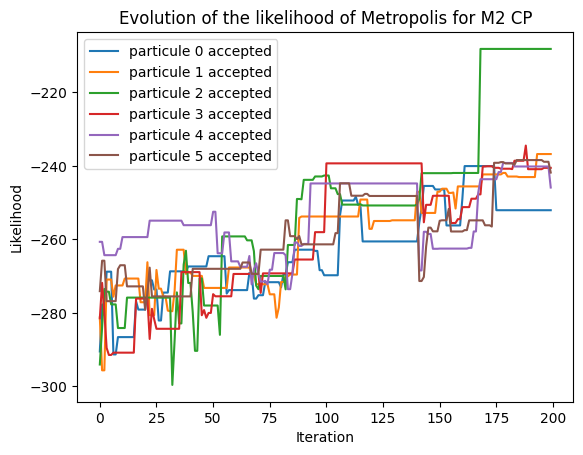

In [9]:
# Plot the evolution of the likelihood for the accepted rules
baseline_name = "M2 CP"
plt.figure()
for seed in range(all_rules[baseline_name].shape[0]):
    plt.plot(all_likelihoods[baseline_name][seed,all_additional_data[baseline_name]["prev_rules_ind"][seed,1:]], label="particule "+ str(seed)+" accepted")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title(f"Evolution of the likelihood of Metropolis for {baseline_name}")
plt.show()


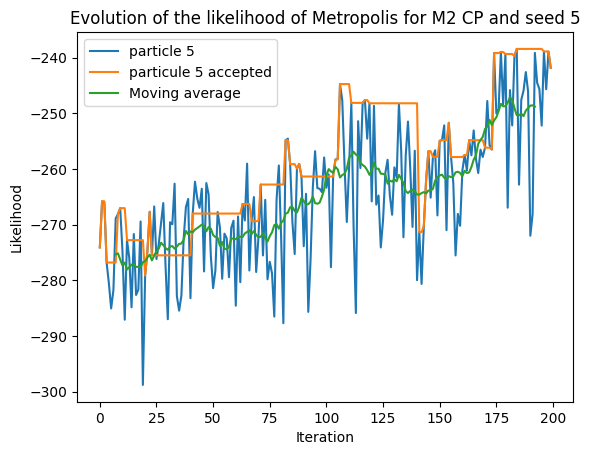

In [10]:
seed = 5
plt.figure()
plt.plot(all_likelihoods[baseline_name][seed, :-1], label="particle "+ str(seed))
plt.plot(all_likelihoods[baseline_name][seed,all_additional_data[baseline_name]["prev_rules_ind"][seed,1:]], label="particule "+ str(seed)+" accepted")

#Plot moving average of the likelihood
window_size = 15
moving_average = np.convolve(all_likelihoods[baseline_name][seed, :-1], np.ones(window_size)/window_size, mode='valid')
plt.plot(np.arange(window_size//2, len(moving_average)+window_size//2), moving_average, label="Moving average")
plt.xlabel("Iteration")
plt.ylabel("Likelihood")
plt.legend()
plt.title(f"Evolution of the likelihood of Metropolis for {baseline_name} and seed " + str(seed))
plt.show()

## Comparaison collecte de données

In [11]:
all_transition_likelihoods[baseline_name]

array([[[-2.50595856, -0.06770852, -0.70540279, ..., -0.0265059 ,
         -1.03516054, -4.45375061],
        [-2.45941091, -0.01093306, -0.24890733, ..., -0.03284167,
         -0.87518287, -4.15568542],
        [-2.67886901, -0.05374017, -0.4914149 , ..., -0.03385546,
         -1.22652543, -4.39427376],
        ...,
        [-2.2335577 , -0.09332484, -0.29436907, ..., -0.03625434,
         -1.04235423, -3.90928102],
        [-2.02323985, -0.04923557, -0.10143337, ..., -0.03399372,
         -1.29884589, -4.009902  ],
        [-2.31560135, -0.04575406, -0.22279359, ..., -0.03601491,
         -1.32289147, -3.9482677 ]],

       [[-2.81008077, -0.06351945, -0.12494808, ..., -0.03461529,
         -1.38502812, -4.78408718],
        [-2.75365782, -0.03411973, -0.71214312, ..., -0.03513824,
         -1.3179034 , -4.45225811],
        [-2.54205537, -0.05230707, -0.32435787, ..., -0.03689542,
         -1.53018987, -4.30543327],
        ...,
        [-2.34518456, -0.04970878, -0.40544757, ..., -

In [12]:
dict_index_transition.keys()

dict_keys(['standing', 'holding', 'holding1', 'holding2', 'transform', 'transformP', 'transformSH', 'transformBH', 'nothing'])

In [13]:
[len(value ) for value in dict_index_transition.values()]

[51, 26, 15, 11, 19, 13, 3, 3, 21]

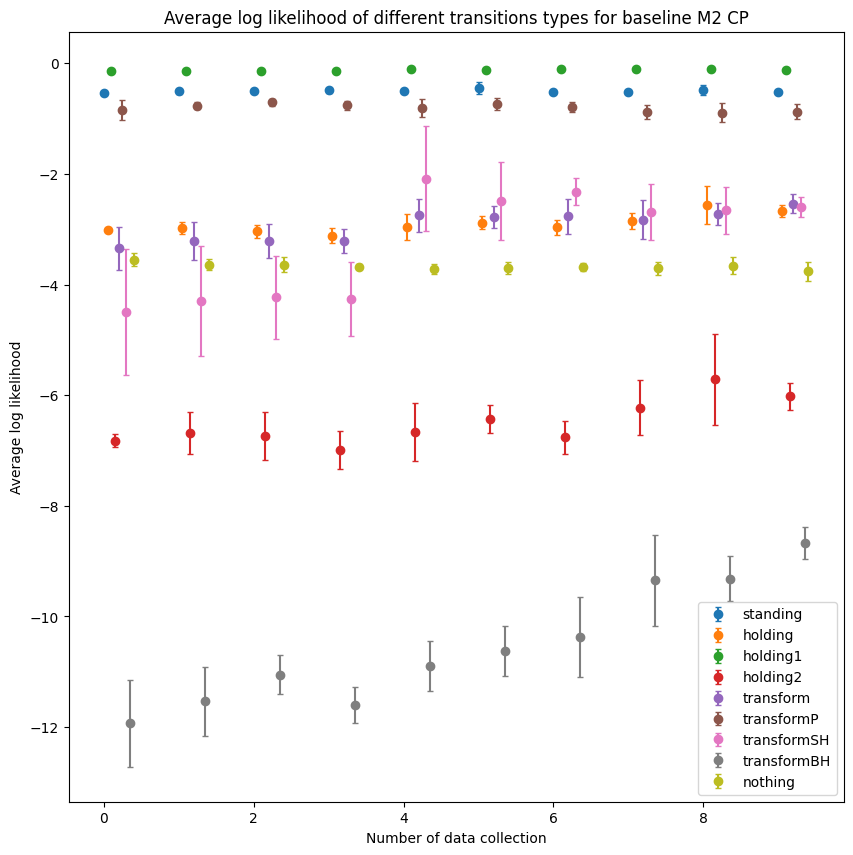

In [16]:
nb_rule_per_collect = 20
transi_type = "nothing"
baseline_name = "M2 CP"
plt.figure(figsize=(10,10))
for incr, transi_type in enumerate(dict_index_transition):
    # Get the best rules for each particle and data collection for each traj type
    _reshaped_rules = all_rules[baseline_name][:,1:].reshape((all_rules[baseline_name].shape[0], (all_rules[baseline_name].shape[1]-1)//nb_rule_per_collect, nb_rule_per_collect))
    _reshaped_transition_likelihoods = all_transition_likelihoods[baseline_name][:,1:,:].reshape((all_transition_likelihoods[baseline_name].shape[0], (all_transition_likelihoods[baseline_name].shape[1]-1)//nb_rule_per_collect, nb_rule_per_collect, all_transition_likelihoods[baseline_name].shape[2]))

    _reshaped_transition_likelihoods = _reshaped_transition_likelihoods[:,:,:,dict_index_transition[transi_type]].mean(axis=3)
    best_rules_ind = np.argmax(_reshaped_transition_likelihoods, axis=2)
    best_transition_lieklihoods = _reshaped_transition_likelihoods[np.arange(_reshaped_transition_likelihoods.shape[0])[:,None], np.arange(_reshaped_transition_likelihoods.shape[1]), best_rules_ind]
    best_rules = _reshaped_rules[np.arange(_reshaped_rules.shape[0])[:,None], np.arange(_reshaped_rules.shape[1]), best_rules_ind]
    plt.errorbar(np.arange(best_rules.shape[1])+ incr*0.05, best_transition_lieklihoods.mean(axis=0), yerr=best_transition_lieklihoods.std(axis=0), label=transi_type, capsize=2, fmt='o')
    
plt.legend()
plt.xlabel("Number of data collection")
plt.ylabel("Average log likelihood")
plt.title(f"Average log likelihood of different transitions types for baseline {baseline_name}")
plt.show()

## Embeddings

In [15]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0))

### t-SNE

In [16]:
#Compute the t-SNE embeddings
proj_embeddings = TSNE(n_components=2).fit_transform(embeddings)

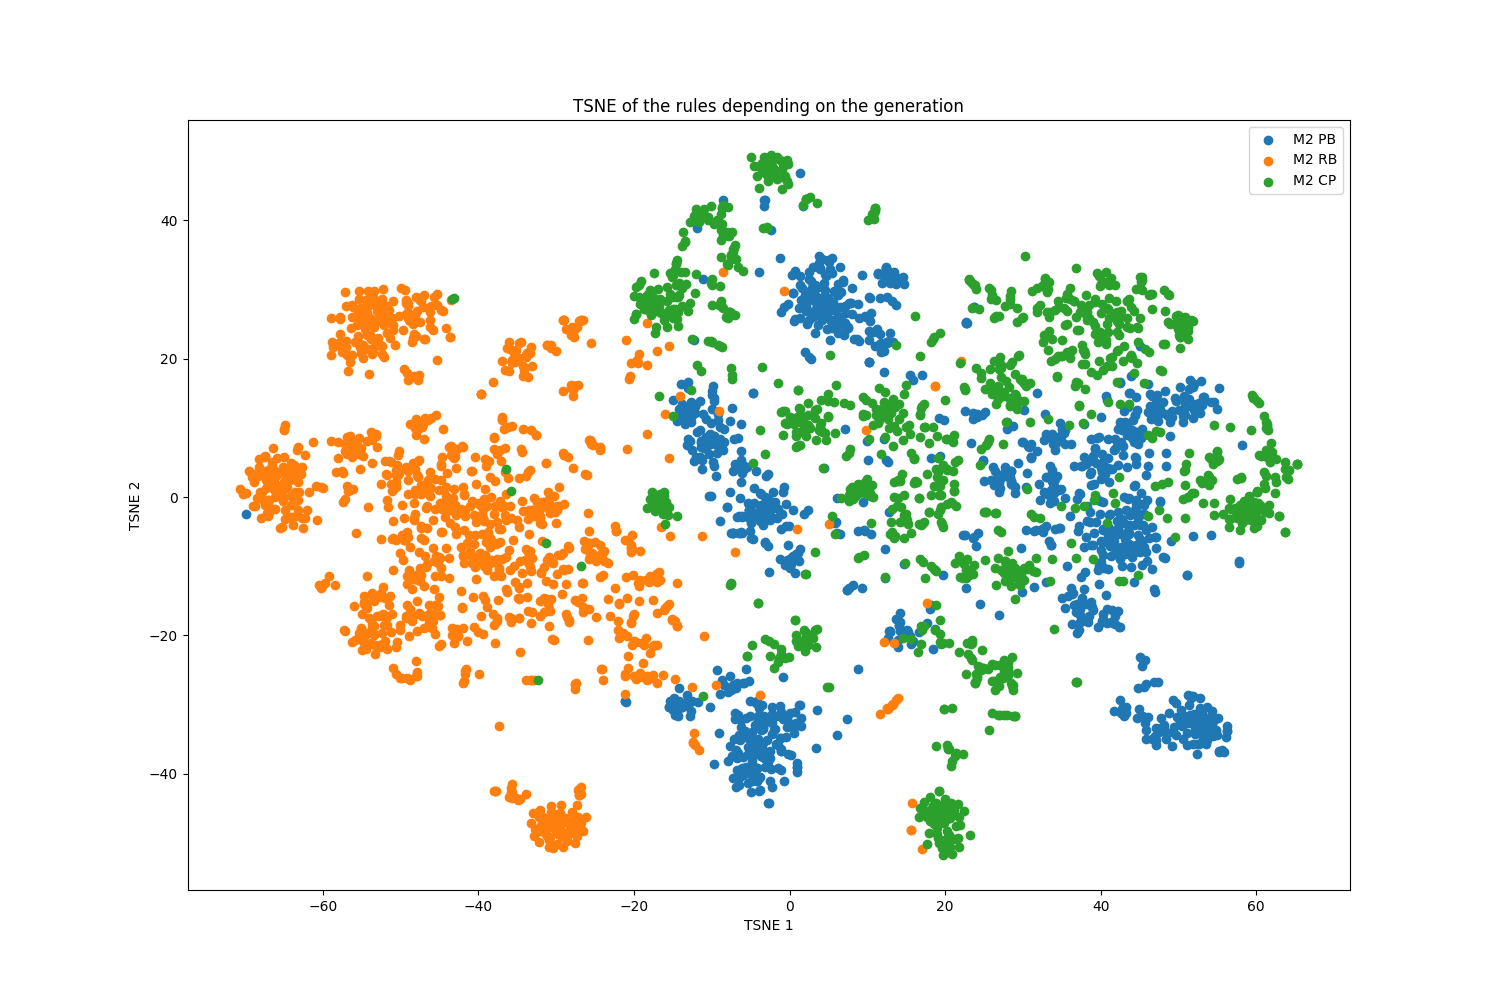

In [17]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

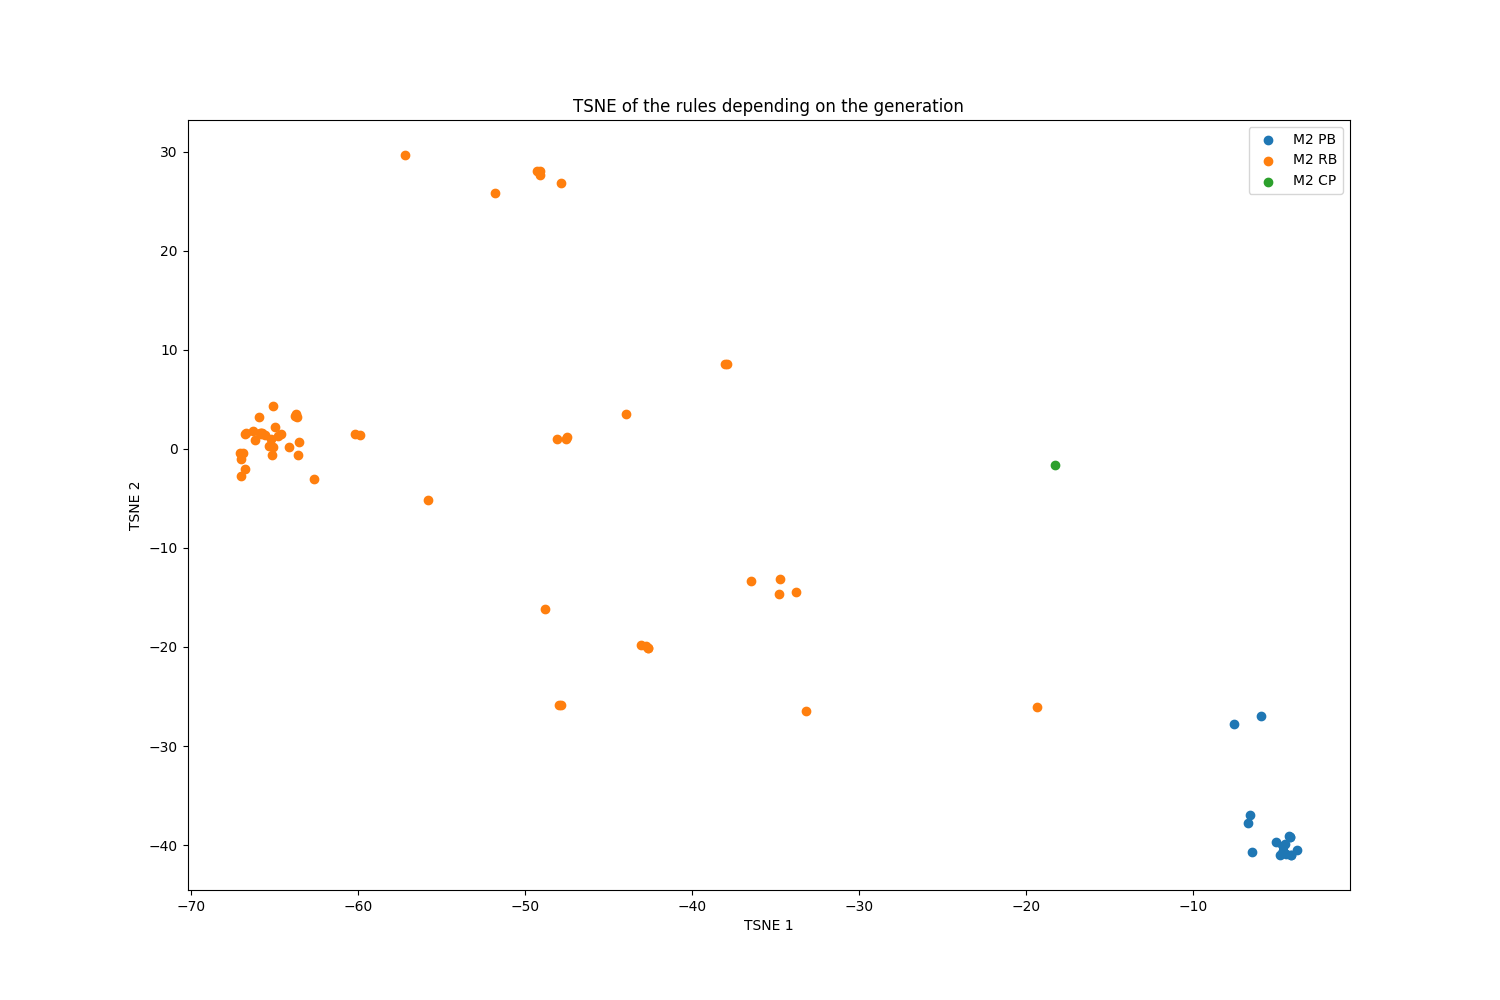

In [18]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("TSNE 1")
plt.ylabel("TSNE 2")
plt.title("TSNE of the rules depending on the generation")
plt.show()

### PCA

In [19]:
#Compute the PCA embeddings
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_embeddings = pca.fit_transform(embeddings)

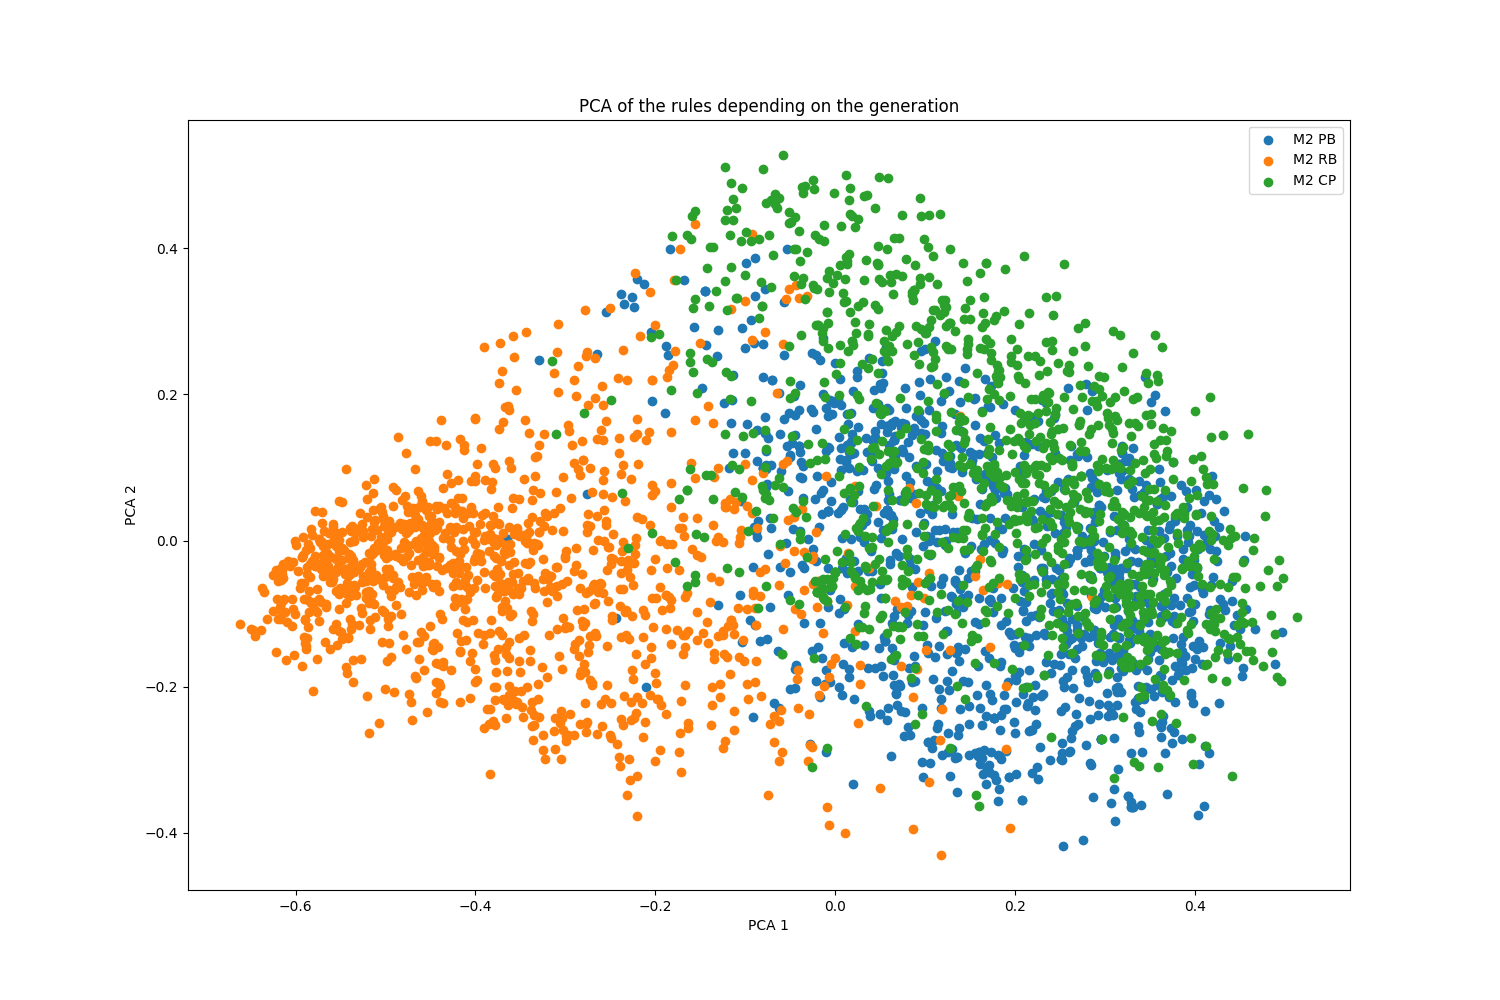

In [20]:
# Enable interactive backend
%matplotlib widget

# Plot the embeddings
plt.figure(figsize=(15,10))
rules = np.concatenate([all_rules[b_name].flatten() for b_name in all_baselines_name], axis=0)
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    plt.scatter(proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),0], proj_embeddings[start_index:start_index+len(all_rules[b_name].flatten()),1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
    
# Add interactive cursor
cursor = mplcursors.cursor(hover=True)
# Define the hover function
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set(text=f"Rule: {(rules[sel.index])}")
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()

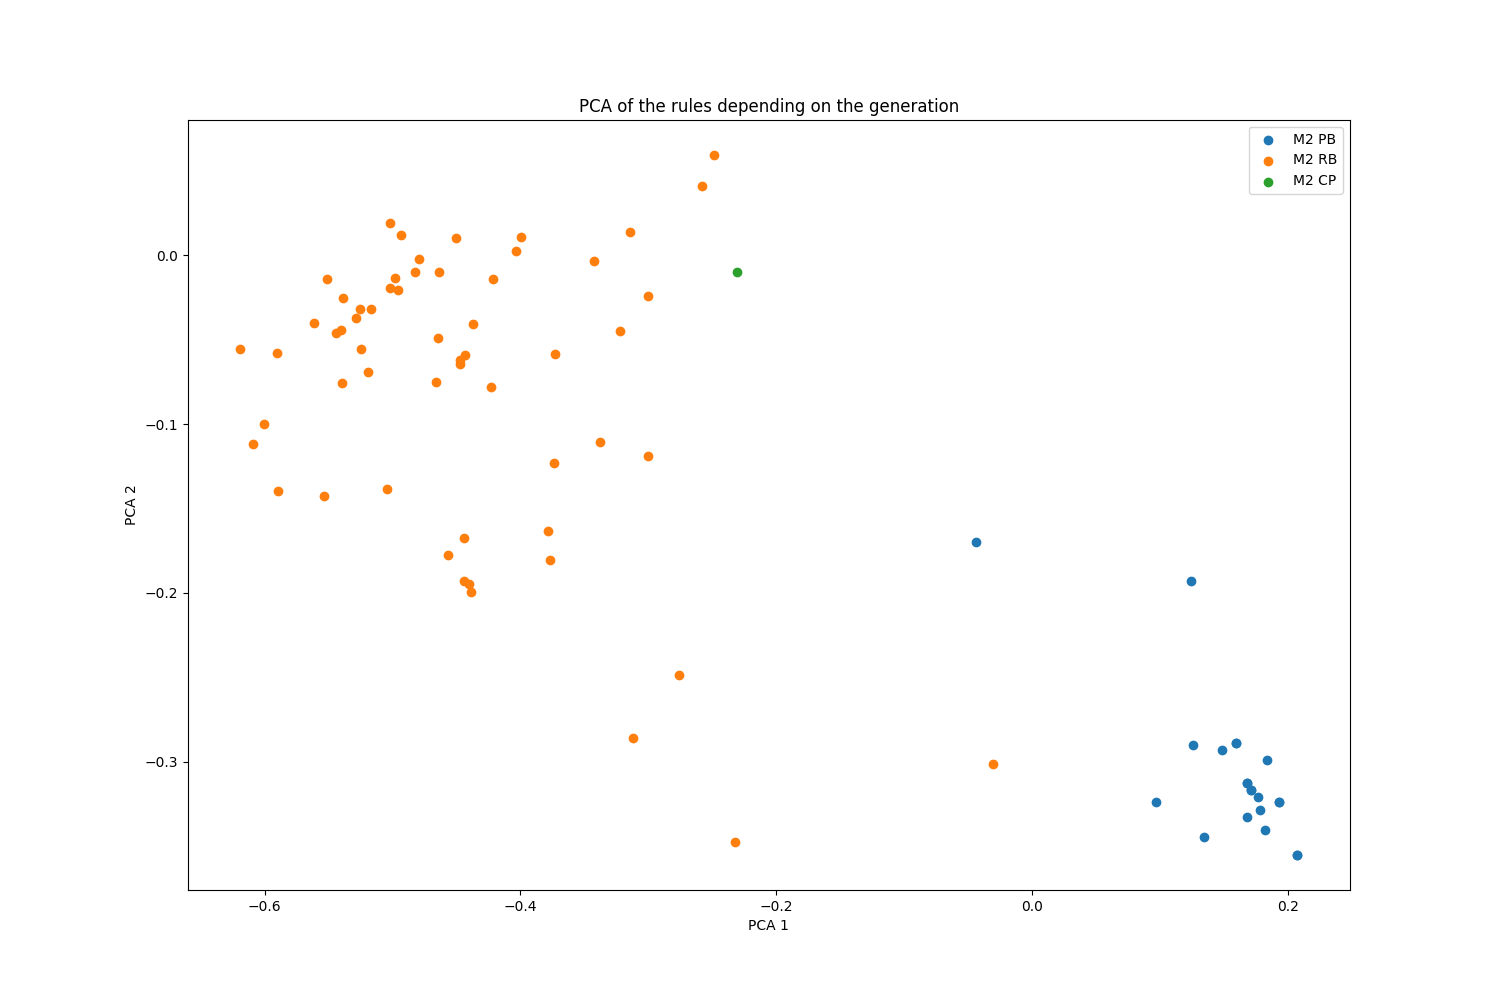

In [21]:
# Plot embeddings with likelihoods high enough
# Plot the embeddings
plt.figure(figsize=(15,10))
likelihoods = np.concatenate([all_likelihoods[b_name].flatten() for b_name in all_baselines_name])
mask_likelihood = likelihoods > -220
start_index = 0
for incr, b_name in enumerate(all_baselines_name):
    mask_index = (np.arange(len(likelihoods))<start_index+len(all_rules[b_name].flatten())) & (np.arange(len(likelihoods))>=start_index)
    plt.scatter(proj_embeddings[mask_index & mask_likelihood,0], proj_embeddings[mask_index & mask_likelihood,1], label=b_name)
    start_index = start_index + len(all_rules[b_name].flatten())
plt.legend()
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of the rules depending on the generation")
plt.show()